In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(1)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 1
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

cuda:1


In [4]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                           
                                           ]))
# TODO: change the normalization parameters

In [6]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
1 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
2 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
3 torch.Size([32, 3, 96, 96]) torch.Size([32, 96, 96])
torch.Size([32, 1, 96, 96])


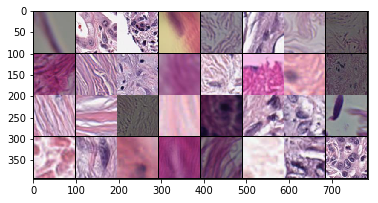

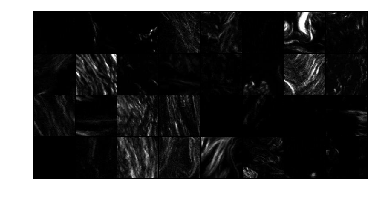

In [7]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [8]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [9]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -ssim(output, targetf)
        
        p = 0.25
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(p*lossMSE.item()) +
                  " " + "lossSSIM: " + str((1-p)*lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [10]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [11]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.55312180519104 lossSSIM: 0.09154412895441055
===> Epoch[1](0/25343): Loss: 0.6447
lossMSE: 0.5410063862800598 lossSSIM: 0.038698713295161724
===> Epoch[1](50/25343): Loss: 0.5797
lossMSE: 0.5330385565757751 lossSSIM: 0.03606613911688328
===> Epoch[1](100/25343): Loss: 0.5691
lossMSE: 0.5336962342262268 lossSSIM: 0.03544580563902855
===> Epoch[1](150/25343): Loss: 0.5691
lossMSE: 0.5359765291213989 lossSSIM: 0.03296442423015833
===> Epoch[1](200/25343): Loss: 0.5689
lossMSE: 0.5444689989089966 lossSSIM: 0.03329982329159975
===> Epoch[1](250/25343): Loss: 0.5778
lossMSE: 0.547530472278595 lossSSIM: 0.03288355004042387
===> Epoch[1](300/25343): Loss: 0.5804
lossMSE: 0.54599928855896 lossSSIM: 0.03270458243787289
===> Epoch[1](350/25343): Loss: 0.5787
lossMSE: 0.5154597759246826 lossSSIM: 0.0292245140299201
===> Epoch[1](400/25343): Loss: 0.5447
lossMSE: 0.5427029132843018 lossSSIM: 0.03132206294685602
===> Epoch[1](450/25343): Loss: 0.5740
lossMSE: 0.5390594601631165 lossSSIM: 